Tensor Field Networks

Implementation of Newtonian gravity demonstration

In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
from toolz.curried import pipe, map, curry

In [4]:
%matplotlib inline

import random
from math import sqrt
import tensorflow as tf
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from tensorfieldnetworks import utils, layers
from tensorfieldnetworks.utils import EPSILON, FLOAT_TYPE

In [5]:
# radial basis functions
rbf_low = 0.
rbf_high = 2.
rbf_count = 30
rbf_spacing = (rbf_high - rbf_low) / rbf_count
centers = tf.lin_space(rbf_low, rbf_high, rbf_count)

In [6]:
# [N, 3]
r = tf.placeholder(FLOAT_TYPE, shape=[None, 3])

# [N, 1, 1]
masses = tf.placeholder(FLOAT_TYPE, shape=[None, 1, 1])

# [N, N, 3]
rij = utils.difference_matrix(r)

# [N, N]
dij = utils.distance_matrix(r)

# rbf : [N, N, rbf_count]
gamma = 1. / rbf_spacing
rbf = tf.exp(-gamma * tf.square(tf.expand_dims(dij, axis=-1) - centers))

# shifted softplus
nonlin = utils.ssp

hidden_dim = rbf_count
output_dim = 1

# single layer, 0 -> 1
with tf.variable_scope(None, "layer1", values=[masses]):
    # [N, 1, 3]
    output = layers.filter_1_output_1(masses, rbf, rij, nonlin=nonlin, 
                                      hidden_dim=hidden_dim, output_dim=output_dim, 
                                      weights_initializer=tf.glorot_uniform_initializer(),
                                      biases_initializer=tf.glorot_uniform_initializer())
    
# accel : [N, 1, 3]
accel = tf.placeholder(FLOAT_TYPE, shape=[None, 1, 3])

# loss : []
loss = tf.nn.l2_loss(accel - output)

optim = tf.train.AdamOptimizer(learning_rate=1.e-3)

train_op = optim.minimize(loss)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
# for plotting

# x : []
x = tf.placeholder(FLOAT_TYPE, shape=(None))

# rbf_plot : [rbf_count]
rbf_plot = tf.exp(-gamma * tf.square(x - centers))

for v in tf.global_variables():
    if 'layer1/F1_to_1/F_1/radial_function/weights1' in v.name and "Adam" not in v.name:
        w1 = v
    elif 'layer1/F1_to_1/F_1/radial_function/biases1' in v.name and "Adam" not in v.name:
        b1 = v
    elif 'layer1/F1_to_1/F_1/radial_function/weights2' in v.name and "Adam" not in v.name:
        w2 = v
    elif 'layer1/F1_to_1/F_1/radial_function/biases2' in v.name and "Adam" not in v.name:
        b2 = v
        
hidden_layer_plot = nonlin(b1 + tf.tensordot(rbf_plot, w1, [[0], [1]]))
R_plot = b2 + tf.tensordot(hidden_layer_plot, w2, [[0], [1]])

In [8]:
def accelerations(points, masses=None):
    """
    inputs:
    -points: a list of 3-tuples of point coordinates
    -masses: a list (of equal length N) of masses
    
    returns: 
    -shape [N, 3] numpy array of accelerations under Newtonian gravity
    """
    accels = []
    if masses is None:
        masses = [1.0 for _ in range(len(points))]
    for i, ri_ in enumerate(points):
        accel_vec = np.array((0., 0., 0.))
        for j, rj_ in enumerate(points):
            rij_ = ri_ - rj_
            dij_ = np.linalg.norm(rij_)
            if (ri_ != rj_).any():
                accel_update = -rij_ / (np.power(dij_, 3) + EPSILON) * masses[j]
                accel_vec += accel_update
        accels.append(accel_vec)
    assert len(accels) == len(points)
    return np.array(accels)


def random_points_and_masses(max_points=10, min_mass=0.5, max_mass=2.0, 
                             max_coord=rbf_high, min_separation=0.5):
    """
    returns:
    -shape [N, 3] numpy array of points, where N is between 2 and max_points
    -shape [N] numpy array of masses
    """
    num_points = random.randint(2, max_points)
    candidate_points = []
    for point in xrange(num_points):
        candidate_points.append(
            np.array([random.uniform(-max_coord, max_coord) for _ in range(3)]))
    
    # remove points that are closer than min_separation
    output_points = []
    for point in candidate_points:
        include_point = True
        for previous_point in output_points:
            if np.linalg.norm(point - previous_point) < min_separation:
                include_point = False
        if include_point:
            output_points.append(point)
    
    points_ = np.array(output_points)
    masses_ = np.random.rand(len(output_points)) * (max_mass - min_mass) + min_mass
    return points_, masses_

In [13]:
xrange = curry(range)

In [16]:
%%time
max_steps = 1001
validation_size = 1000
print_freq = 1000

F1_y_vals = []
x_vals = [index * rbf_high / rbf_count for index in xrange(rbf_count + 1)]

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# training
min_separation = 0.5
for step in xrange(max_steps):
    rand_points, rand_masses = random_points_and_masses(max_points=10, 
                                                        min_separation=min_separation)
    rand_masses_m = np.reshape(rand_masses, [len(rand_masses), 1, 1])
    sess.run(train_op, feed_dict={r: rand_points, 
                                  masses: rand_masses_m, 
                                  accel: np.expand_dims(accelerations(rand_points,
                                                                      rand_masses), axis=-2)})
    
    # print performance on different random point set every print_freq steps
    if step % print_freq == 0:
        loss_sum = 0.
        for _ in xrange(validation_size):
            validation_points, validation_masses = random_points_and_masses(max_points=50,
                                                                            min_separation=min_separation)
            validation_masses_m = np.reshape(validation_masses, [len(validation_masses), 1, 1])
            validation_loss = sess.run(loss, feed_dict={r: validation_points, 
                                                        masses: validation_masses_m, 
                                                        accel: np.expand_dims(
                                                            accelerations(validation_points, 
                                                                          validation_masses), axis=-2)})
            loss_sum += validation_loss
        print("Step %d: validation loss = %.3f" % (step, loss_sum / validation_size))

        # for plotting radial function
        y_vals = []
        for x_val in x_vals:
            y_vals.append(sess.run(R_plot, feed_dict={x: x_val}))
        F1_y_vals.append((step, y_vals))

Step 0: validation loss = 17321.238
Step 1000: validation loss = 3.468
CPU times: user 51.2 s, sys: 652 ms, total: 51.8 s
Wall time: 47.8 s


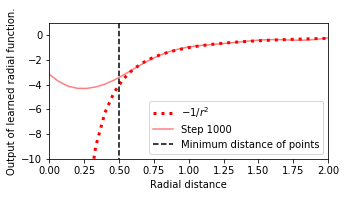

In [17]:
# plot radial function and compare with -1/r^2

radial_fig = plt.figure(figsize=(5,2.5))
ax = radial_fig.add_subplot(1,1,1)

min_index_cutoff = int((1 / sqrt(40.) - rbf_low) / rbf_spacing)
ax.plot(x_vals[min_index_cutoff:], [-1 / r_**2 for r_ in x_vals[min_index_cutoff:]], "r:", lw=3, label="$-1/r^2$")

for step, y_vals in F1_y_vals[1:]:
    line, = ax.plot(x_vals, y_vals, 'r', alpha=0.5, label="Step {}".format(step))
    line.set_ydata(y_vals)

ax.plot([min_separation, min_separation], [10,-50], 'k--', label="Minimum distance of points")
ax.set_ylabel("Output of learned radial function.")
ax.set_xlabel("Radial distance")
ax.set_xlim(0., 2.0)
ax.set_ylim(-10, 1.)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
radial_fig.canvas.draw()